# Tutorial: Estimating Bayes factors

 >"I have approximate answers and possible beliefs and different degrees of uncertainty about different things, but I am not absolutely sure of anything [...]" - Richard Feynman 

This lab introduces the Bayes factor and its implementation in R.

## Goals:
* Learn how to use the [BayesFactor](https://cran.r-project.org/web/packages/BayesFactor/BayesFactor.pdf) library
* Learn how to quantify the amount of evidence for alternative hypotheses (instead of fully supporting or fully rejecting them altogether) 

This lab draws on [Richard Morey's introduction](https://richarddmorey.github.io/BayesFactor/#help) to the BayesFactor library.

---
#  What is a Bayes factor? 
  * The Bayes factor is the analytical response to the question: What is the strength of the evidence for my model, given a competing hypothesis? If you're interested in the *relative* weight of evidence for competing hypotheses, then the Bayes Factor is for you. 
  * The Bayes factor is a ratio of the evidence for one model over another. It can be expressed as the relative likelihood of the data given a set of hypotheses: 
  
  $$BF = \frac{P(D|H_1)}{P(D|H_0)}$$
  
* Similar to the Bayesian Information Criterion (BIC), the Bayes factor penalizes model complexity. 


Look [here](http://statmath.wu.ac.at/research/talks/resources/talkheld.pdf) and [here](https://link.springer.com/article/10.3758/s13423-017-1262-3) for a more in-depth treatment. 

---
# Implementing the Bayes factor with a simple example

First, install and load the `BayesFactor` library. Also load `tidyverse` for some data manipulation. 

In [1]:
install.packages("BayesFactor") #install 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘elliptic’, ‘contfrac’, ‘deSolve’, ‘coda’, ‘pbapply’, ‘mvtnorm’, ‘gtools’, ‘MatrixModels’, ‘hypergeo’, ‘RcppEigen’




In [2]:
library(BayesFactor)
library(tidyverse) # also import tidyverse for data manipulation
# there are functions to calculate BF for many different tests, including correlations, linear regresssion, and t-tests - uncomment below to see them all
# lsf.str("package:BayesFactor") # outputs a list of all of the functions in the package

Loading required package: coda

Loading required package: Matrix

************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************



Let's start with a simple example. We'll use the `sleep` dataset included in R to calculate the evidence for the null hypothesis that there is no effect of sleep deprivation on reaction time. As a reminder, here's what the `sleep` dataset looks like. 

In [3]:
sleep
?sleep

extra,group,ID
<dbl>,<fct>,<fct>
0.7,1,1
-1.6,1,2
-0.2,1,3
-1.2,1,4
-0.1,1,5
3.4,1,6
3.7,1,7
0.8,1,8
0.0,1,9


This is a within-subjects dataset measuring the impact of acertain drug on sleep. `extra` is the change in amount of sleep (in hours), `group` is whether they received the treatment, and `ID` is the participant identifier.

Let's try running a traditional t-test on this, before we get into Bayes Factors. 

In [14]:
## Compute difference scores
# ?spread
sleep$group <- as.factor(c(rep("group1",10),rep("group2",10))) # resetting the group values to avoid having integers as column names
sleep_wd <- sleep %>%
  spread(key=group,value=extra) %>% # wide format - all measurements for one participant are in same row
  mutate(diffScores= group1 - group2) # in case you want to look at the differences. 
head(sleep_wd)

## Traditional paired t-test
t.test(sleep_wd$group1,sleep_wd$group2,paired=TRUE) 

,ID,group1,group2,diffScores
,<fct>,<dbl>,<dbl>,<dbl>
1,1,0.7,1.9,-1.2
2,2,-1.6,0.8,-2.4
3,3,-0.2,1.1,-1.3
4,4,-1.2,0.1,-1.3
5,5,-0.1,-0.1,0.0
6,6,3.4,4.4,-1.0



	Paired t-test

data:  sleep_wd$group1 and sleep_wd$group2
t = -4.0621, df = 9, p-value = 0.002833
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.4598858 -0.7001142
sample estimates:
mean of the differences 
                  -1.58 


In the test above, the difference scores are found to be significantly different from 0 ($t=-4.06$, $p<0.005$ ), with group 1 values being smaller than group 2 values. Now let's look at Bayes factors for this same example. 

In [15]:
# ?ttestBF
bf = ttestBF(x = sleep_wd$group1,y=sleep_wd$group2, paired=TRUE) # this is the BF object
bf # the relative evidence for the alternative hypothesis (nonzero difference between conditions)

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 17.25888 ±0%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS


Note the denominator specification in the output! Make sure to interpret these correctly. Here, the denominator is the null hypothesis, so this is the relative evidence for the alternative hypothesis, that the difference in sleep gotten between conditions is non-zero. 

In [ ]:
1/bf #the relative evidence for the null hypothesis (no difference between conditions)

Bayes factor analysis
--------------
[1] Null, mu=0 : 0.05794119 ±0%

Against denominator:
  Alternative, r = 0.707106781186548, mu =/= 0 
---
Bayes factor type: BFoneSample, JZS


As you can see, the evidence for the alternative (17.25) is much higher than for the null (0.06).

Now let's test a directional hypothesis: Instead of determining *Is $x$ different from $y$?*, we'll ask more specifically *Is $x$ **less than** $y$?*. To do this, set the `nullInterval` argument to the range of interest. Here, we will compute the weight of evidence for the alternative hypothesis that the difference in the amount of sleep gotten between conditions will be negative, so the range is from `-Inf` to `0`.

In [17]:
#we can also test a directional hypothesis  
bfInterval = ttestBF(x = sleep_wd$diffScores, nullInterval=c(-Inf,0)) #here we test the hypothesis that the difference is less than 0
bfInterval

Bayes factor analysis
--------------
[1] Alt., r=0.707 -Inf<d<0    : 34.41694  ±0%
[2] Alt., r=0.707 !(-Inf<d<0) : 0.1008246 ±0.06%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS


Here you can see the evidence for both possible situations evalauated against the null as the denominator. Line 1 shows the evidence that the difference between conditions is negative, and line 2 shows the evidence tha the difference between conditions is  non-negative (positive). You can see that the evidence is more strongly in favor of a negative difference (34.42) than a positive difference (0.10).

Now, what if you were interested in directly comparing the evidence for a negative difference with the evidence for a positive difference? You can directly manipulate the Bayes Factor object to achieve this. Since both of these evidence ratios have the same denominator, we can directly compare these results like this: 

In [18]:
bfNegative = bfInterval[1] / bfInterval[2] #here we compare the evidence for a negative difference against the evidence for a positive one

bfNegative
#note the denominator specification

Bayes factor analysis
--------------
[1] Alt., r=0.707 -Inf<d<0 : 341.3547 ±0.06%

Against denominator:
  Alternative, r = 0.707106781186548, mu =/= 0 !(-Inf<d<0) 
---
Bayes factor type: BFoneSample, JZS


And like before, we can take the inverse of this ratio to find the evidence for a positive difference against the evidence for a negative one: 

In [19]:
bfPositive = 1 / bfNegative #as you might expect, the evidence for a positive difference is miniscule 
bfPositive

Bayes factor analysis
--------------
[1] Alt., r=0.707 !(-Inf<d<0) : 0.002929504 ±0.06%

Against denominator:
  Alternative, r = 0.707106781186548, mu =/= 0 -Inf<d<0 
---
Bayes factor type: BFoneSample, JZS


Now we've conducted Bayes factor analyses for three different alternative hypotheses: that the difference scores are non-zero, that the difference scores are negative, and that the difference scores are positive. You can use the `plot` function in the `BayesFactor` package to visually evaluate the difference in the relative evidence for each of these hypotheses.

In [21]:
allbf = c(bf, bfInterval)

allbf

Bayes factor analysis
--------------
[1] Alt., r=0.707             : 17.25888  ±0%
[2] Alt., r=0.707 -Inf<d<0    : 34.41694  ±0%
[3] Alt., r=0.707 !(-Inf<d<0) : 0.1008246 ±0.06%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS


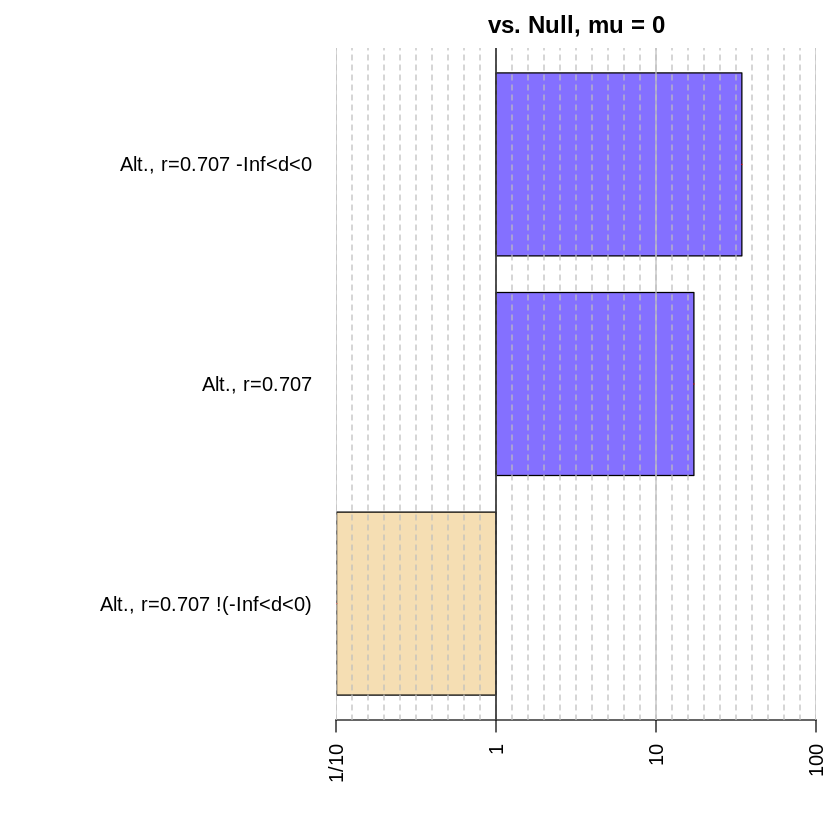

In [22]:
plot(allbf)

Ahhhh... so lovely :)

---
# Calculating the Bayes Factor for comparison of candidate mixed effect models

Now let's see how to apply this to hierarchical linear regression, using the `ToothGrowth` data set. The dependent variable is `len`, the length of the tooth, and the independent variables are `supp`, the type of supplement they took (Vitamin C or Orange Juice), and `dose`, the amount of supplement they took.

In [24]:
data(ToothGrowth)
head(ToothGrowth)
# ?ToothGrowth

# model log10 of dose instead of dose directly
ToothGrowth$dose = log10(ToothGrowth$dose)

# Classic analysis for comparison
lmToothGrowth <- lm(len ~ supp + dose + supp:dose, data=ToothGrowth)
summary(lmToothGrowth)

,len,supp,dose
,<dbl>,<fct>,<dbl>
1,4.2,VC,0.5
2,11.5,VC,0.5
3,7.3,VC,0.5
4,5.8,VC,0.5
5,6.4,VC,0.5
6,10.0,VC,0.5



Call:
lm(formula = len ~ supp + dose + supp:dose, data = ToothGrowth)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.5433 -2.4921 -0.5033  2.7117  7.8567 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  20.6633     0.6791  30.425  < 2e-16 ***
suppVC       -3.7000     0.9605  -3.852 0.000303 ***
dose         21.3102     2.7631   7.712  2.3e-10 ***
suppVC:dose   8.8529     3.9076   2.266 0.027366 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.72 on 56 degrees of freedom
Multiple R-squared:  0.7755,	Adjusted R-squared:  0.7635 
F-statistic:  64.5 on 3 and 56 DF,  p-value: < 2.2e-16


The classic analysis shows low p-values for the effects of supplement type and dose on tooth growth with an interaction effect. We can use the `lmBF` function to calculate the Bayes factors for all potential models of interest against a null intercept-only model. 

In [25]:
full <- lmBF(len ~ supp + dose + supp:dose, data=ToothGrowth) #all predictors + interaction
noInteraction <- lmBF(len ~ supp + dose, data=ToothGrowth) #no interaction
onlyDose <- lmBF(len ~ dose, data=ToothGrowth) #only dose
onlySupp <- lmBF(len ~ supp, data=ToothGrowth) #only supplementation

allBFs <- c(full, noInteraction, onlyDose, onlySupp)
allBFs

Bayes factor analysis
--------------
[1] supp + dose + supp:dose : 1.651389e+15 ±3.73%
[2] supp + dose             : 1.54362e+15  ±1.42%
[3] dose                    : 2.769593e+13 ±0.01%
[4] supp                    : 1.198757     ±0.01%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS


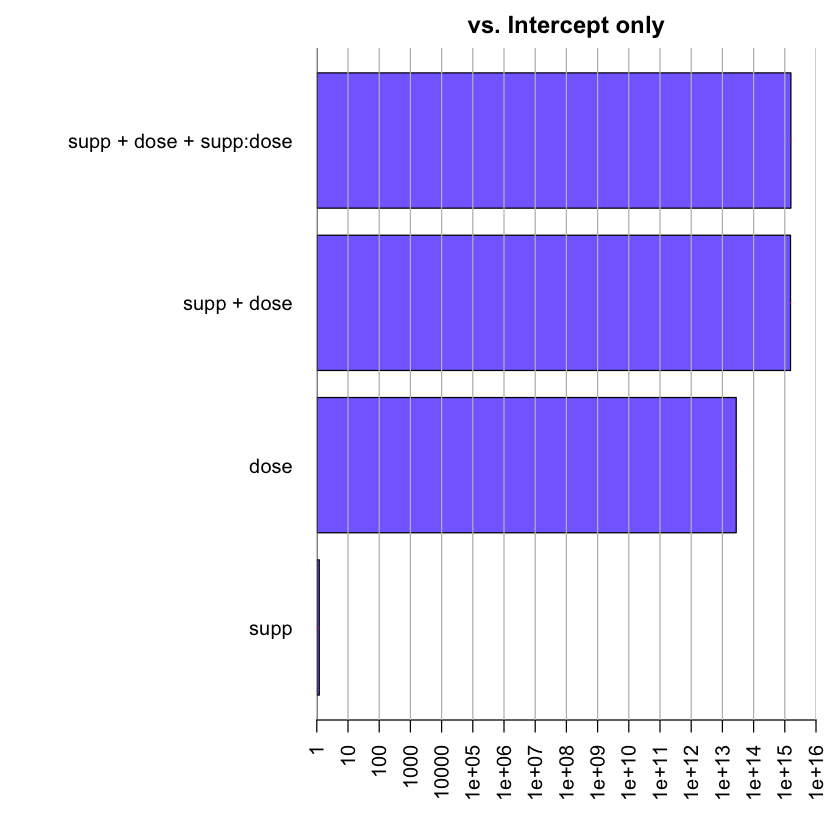

In [ ]:
plot(allBFs)

The results from the interaction model and the no-interaction model are close. Let's directly evaluate these two hypotheses against one another.

In [ ]:
full / noInteraction

Bayes factor analysis
--------------
[1] supp + dose + supp:dose : 1.02911 ±1.56%

Against denominator:
  len ~ supp + dose 
---
Bayes factor type: BFlinearModel, JZS


Even after direct comparison, there's no clear difference between the two models. It would probably depend on the context what you decide to do with this information - if there's prior literature to suggest that the interaction should play a role, you might lean toward using the more complex model even though the difference between the two isn't dramatic in this case. Otherwise, it would make sense to stick with the simpler model. 

*Notebook authored by Krista Bond and edited by Charles Wu, Patience Stevens, and Amy Sentis.*